## This is the softmax workbook for ECE 239AS Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

We thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  These are the functions in the cs231n folders and code in the jupyer notebook to preprocess and show the images.  The classifiers used are based off of code prepared for CS 231n as well.

The goal of this workbook is to give you experience with training a softmax classifier.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [4]:
from nndl import Softmax

In [57]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train)) # 10
num_features = X_train.shape[1] # 3073

softmax = Softmax(dims=[num_classes, num_features])


#### Softmax loss

In [102]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples

loss = softmax.loss(X_train, y_train)

In [103]:
print(loss)

2.3277607028048966


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this value make sense?

#### Softmax gradient

In [122]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)


numerical: 2.920730 analytic: 2.920730, relative error: 1.208490e-08
numerical: -3.834913 analytic: -3.834913, relative error: 4.147408e-09
numerical: -0.321159 analytic: -0.321159, relative error: 3.593586e-08
numerical: 3.183140 analytic: 3.183140, relative error: 1.864514e-08
numerical: -2.074813 analytic: -2.074813, relative error: 2.244317e-09
numerical: -1.862010 analytic: -1.862010, relative error: 2.958659e-09
numerical: -1.339883 analytic: -1.339883, relative error: 4.017684e-08
numerical: -0.276906 analytic: -0.276906, relative error: 5.595828e-08
numerical: 2.755894 analytic: 2.755894, relative error: 1.519300e-08
numerical: 0.363444 analytic: 0.363444, relative error: 2.195274e-07


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [123]:
import time

In [127]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} / {} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.


Normal loss / grad: 2.328603106286459 / 314.22938501201025 computed in 0.08777117729187012s
Vectorized loss / grad: 2.3286031062864594 / 314.22938501201025 computed in 0.002123117446899414s
difference in loss / grad: -4.440892098500626e-16 / 2.1424556598116952e-13 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

## Question:

How should the softmax gradient descent training step differ from the svm training step, if at all?

iteration 0 / 1500: loss 2.4317307500757495
iteration 100 / 1500: loss 2.0764544486933527
iteration 200 / 1500: loss 2.041099823702152
iteration 300 / 1500: loss 1.9975840006074082
iteration 400 / 1500: loss 1.9653625120753042
iteration 500 / 1500: loss 1.8938642638542706
iteration 600 / 1500: loss 1.9182242782817402
iteration 700 / 1500: loss 1.8777479310185856
iteration 800 / 1500: loss 1.9509633672114237
iteration 900 / 1500: loss 1.888956726317336
iteration 1000 / 1500: loss 1.939164912274656
iteration 1100 / 1500: loss 1.8303067997518605
iteration 1200 / 1500: loss 1.9075956321124898
iteration 1300 / 1500: loss 1.7994161852340125
iteration 1400 / 1500: loss 1.7605887989486957
That took 2.3903911113739014s


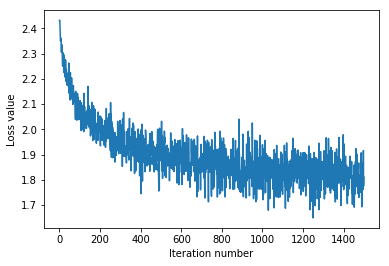

In [138]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time

tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [143]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.38126530612244897
validation accuracy: 0.38


## Optimize the softmax classifier

You may copy and paste your optimization code from the SVM here.

In [144]:
np.finfo(float).eps

2.220446049250313e-16

iteration 0 / 1500: loss 2.3688152928274544
iteration 100 / 1500: loss 2.1181067576715025
iteration 200 / 1500: loss 1.9692582330104205
iteration 300 / 1500: loss 1.9443432557535418
iteration 400 / 1500: loss 1.9832119164017883
iteration 500 / 1500: loss 1.9025085633187286
iteration 600 / 1500: loss 1.9607715900120053
iteration 700 / 1500: loss 1.9059581165679464
iteration 800 / 1500: loss 1.8473382472762239
iteration 900 / 1500: loss 1.7526959172891958
iteration 1000 / 1500: loss 1.7922641830944783
iteration 1100 / 1500: loss 1.799277703160305
iteration 1200 / 1500: loss 1.7340054341891704
iteration 1300 / 1500: loss 1.8545004510896765
iteration 1400 / 1500: loss 1.6611358338468716


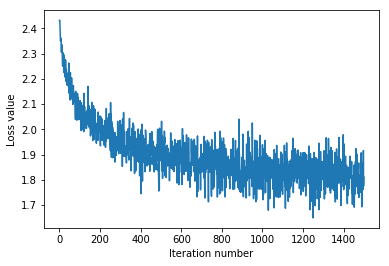

validation accuracy: 0.38
test accuracy: 0.379
iteration 0 / 1500: loss 2.38256209169065
iteration 100 / 1500: loss 1.8981865606435744
iteration 200 / 1500: loss 1.8384461997522528
iteration 300 / 1500: loss 1.8164720185084076
iteration 400 / 1500: loss 1.768885134222806
iteration 500 / 1500: loss 1.7554487147415563
iteration 600 / 1500: loss 1.8353586299968083
iteration 700 / 1500: loss 1.7762818889479477
iteration 800 / 1500: loss 1.8086561141894464
iteration 900 / 1500: loss 1.7733283640524666
iteration 1000 / 1500: loss 1.6597983994019274
iteration 1100 / 1500: loss 1.733988275250087
iteration 1200 / 1500: loss 1.7562400143883963
iteration 1300 / 1500: loss 1.7732308161654533
iteration 1400 / 1500: loss 1.7388563303871973


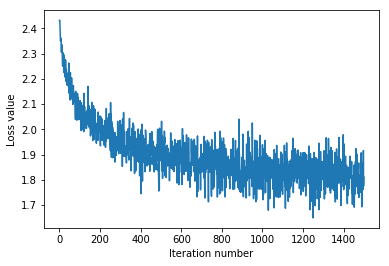

validation accuracy: 0.422
test accuracy: 0.388
iteration 0 / 1500: loss 2.3080513334595625
iteration 100 / 1500: loss 1.845595739772732
iteration 200 / 1500: loss 1.7262885319863828
iteration 300 / 1500: loss 1.8445586622172894
iteration 400 / 1500: loss 1.7534916292506597
iteration 500 / 1500: loss 1.755993391587337
iteration 600 / 1500: loss 1.8055662525114058
iteration 700 / 1500: loss 1.8476732078992535
iteration 800 / 1500: loss 1.6911154079333839
iteration 900 / 1500: loss 1.7185530141397514
iteration 1000 / 1500: loss 1.6988715655656341
iteration 1100 / 1500: loss 1.745439615608732
iteration 1200 / 1500: loss 1.7472419765153324
iteration 1300 / 1500: loss 1.703817172618251
iteration 1400 / 1500: loss 1.7020173832468048


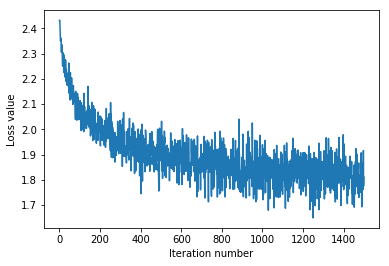

validation accuracy: 0.42
test accuracy: 0.389
iteration 0 / 1500: loss 2.391029996491945
iteration 100 / 1500: loss 1.8438732329207044
iteration 200 / 1500: loss 1.8218695382756926
iteration 300 / 1500: loss 1.8620384877840672
iteration 400 / 1500: loss 1.7767773879913713
iteration 500 / 1500: loss 1.8405865658446001
iteration 600 / 1500: loss 1.8446501614436321
iteration 700 / 1500: loss 1.7417533251658888
iteration 800 / 1500: loss 1.6677069873337893
iteration 900 / 1500: loss 1.7887322292412642
iteration 1000 / 1500: loss 1.8618829616752952
iteration 1100 / 1500: loss 1.6925518239727477
iteration 1200 / 1500: loss 1.6318721247148085
iteration 1300 / 1500: loss 1.848846999547901
iteration 1400 / 1500: loss 1.740386973195248


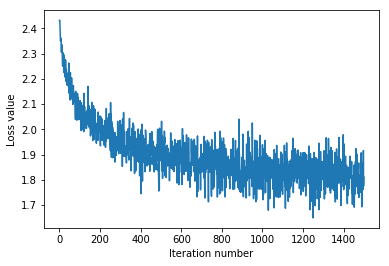

validation accuracy: 0.398
test accuracy: 0.382


In [157]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the Softmax classifier with different learning rates and 
#     evaluate on the validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best validation accuracy corresponding to the best validation error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
# ================================================================ #

learning_rates = [1e-7, 5e-7, 1e-6, 5e-6]
for a in learning_rates:  
    loss_history = softmax.train(X_train, y_train, learning_rate=a,
                      num_iters=1500, verbose=True)
    plt.plot(loss_hist)
    plt.xlabel('Iteration number')
    plt.ylabel('Loss value')
    plt.show()

    y_val_pred = softmax.predict(X_val)
    print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred))))
    
    y_test_pred = softmax.predict(X_test)
    print('test accuracy: {}'.format(np.mean(np.equal(y_test, y_test_pred))))

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #
